In [1]:
from sklearn.datasets import load_iris
import pennylane as qml
import numpy as np
from pennylane.optimize import AdamOptimizer
import matplotlib.pyplot as plt

In [2]:
X, Y = load_iris(return_X_y=True)

X_train_0 = X[0:30]
X_train_1 = X[50:80]
X_train = np.vstack((X_train_0, X_train_1))

Y_train_0 = Y[0:30]
Y_train_1 = Y[50:80]
Y_train = np.vstack((Y_train_0, Y_train_1)).flatten()

X, Y = load_iris(return_X_y=True)

X_test_0 = X[30:50]
X_test_1 = X[80:100]
X_test = np.vstack((X_test_0, X_test_1))

Y_test_0 = Y[30:50]
Y_test_1 = Y[80:100]
Y_test = np.vstack((Y_test_0, Y_test_1)).flatten()

In [3]:
X_train = (X_train - X_train.min(axis=0)) / (X_train.max(axis=0) - X_train.min(axis=0))
X_test = (X_test - X_test.min(axis=0)) / (X_test.max(axis=0) - X_test.min(axis=0))

In [4]:
qubits_num = 4
layers_num = 2

dev = qml.device("default.qubit",wires=qubits_num)

In [34]:
class VQC:
    def __init__(self):
        # 3 => U3(theta, phi, lambda)
        self.params = (0.01 * np.random.randn(layers_num, qubits_num, 3))
        params = [-0.61058476, -0.23619078, -0.67559108]
        self.params = [ 
            [params, params, params, params],
            [params, params, params, params],
        ]
        self.bestparams = self.params
        self.bestcost = 10
        
        self.opt = AdamOptimizer(0.125)
        
        self.weights = []
        self.costs = []
        self.accuracies = []
        
    def fit(self, X_train, Y_train, epoch=300):
        batch_size = 20

        for turn in range(epoch):
            # Update the weights by one optimizer step
            batch_index = np.random.randint(0, len(X_train), (batch_size,))
            X_train_batch = X_train[batch_index]
            Y_train_batch = Y_train[batch_index]
            self.params = self.opt.step(lambda v: cost(v, X_train_batch, Y_train_batch), self.params)

            cost_now = cost(self.params, X_train, Y_train)
            acc_now = accuracy(self.params, X_train, Y_train) 

            if cost_now < self.bestcost:
                self.bestcost = cost_now
                self.bestparams = self.params
            
            self.weights.append(self.params)
            self.costs.append(cost_now)
            self.accuracies.append(acc_now)
            
            print(
                "Turn: {:5d} | Cost: {:0.7f} | Accuracy: {:0.2f}% ".format(
                turn, cost_now, acc_now * 100
            ))
            
    def score(self, X_test, Y_test):
        predictions = [ predict(self.bestparams, data) for data in X_test ]
        acc = accuracy(self.bestparams, X_test, Y_test)
        
        print("FINAL ACCURACY: {:0.2f}%".format(acc * 100))

In [32]:
@qml.qnode(dev)
def circuit(params, data):
    angles = [ i  * np.pi for i in data ]

    for i in range(qubits_num):
        qml.RX(angles[i], wires=i)
        qml.Rot( *params[0, i], wires=i )

    qml.CZ(wires=[1, 0])
    qml.CZ(wires=[1, 2])
    qml.CZ(wires=[2, 3])
    qml.CZ(wires=[0, 3])

    for i in range(qubits_num):
        qml.Rot( *params[1, i], wires=i )
    
    # PauliZ measure => 1 -> |0>  while -1 -> |1>
    return qml.expval(qml.PauliZ(0)), qml.expval(qml.PauliZ(1)), qml.expval(qml.PauliZ(2)), qml.expval(qml.PauliZ(3))

In [7]:
import qiskit
import numpy as np
from qiskit import QuantumCircuit
from qiskit import Aer, execute

unitary_backend = Aer.get_backend('unitary_simulator')
qasm_backend = Aer.get_backend('qasm_simulator')

In [8]:
def predict(params, data):
    qcircuit = QuantumCircuit(4, 4)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])
        
    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[2], qubits[3])
    qcircuit.cz(qubits[0], qubits[3])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
    
    # the measurement
    qcircuit.measure([0, 1, 2, 3], [0, 1, 2, 3])

    # job execution
    shots = 1000
    job_sim = execute(qcircuit, qasm_backend, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qcircuit)

    p1 = (counts.get('1000', 0) + counts.get('1001', 0) + counts.get('1010', 0) + counts.get('1011',0) + \
         counts.get('1100',0) + counts.get('1101',0) + counts.get('1110',0) + counts.get('1111',0)) / shots
    
    if p1 > 0.5:
        return 1
    else:
        return 0

In [9]:
def cost(weights, datas, labels):
    loss = 0
    
    for i, data in enumerate(datas):
        # like [-1, 1, 1]
        measured = circuit(weights, data)

        p = measured[0]
        if labels[i] == 0:
            loss += (1 - p) ** 2
        else:
            loss += (-1 - p) ** 2
            
        
    return loss / len(datas)

In [10]:
def accuracy(weights, datas, labels):
    predictions = [ predict(weights, data) for data in datas ]
    
    acc = 0
    for i, p in enumerate(predictions):
        if p == labels[i]:
            acc += 1
    
    return acc / len(predictions)

In [35]:
vqc = VQC()
vqc.fit(X_train, Y_train, epoch=1)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:9: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[0][i], qubits[i])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:17: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[1][i], qubits[i])


Turn:     0 | Cost: 0.4099047 | Accuracy: 100.00% 


In [16]:
print(vqc.weights[26])

[[[-0.61058476 -0.23619078 -0.67559108]
  [-1.80790905  1.63540309  0.00804188]
  [ 0.00743875 -0.00383477  0.00555999]
  [ 0.71276441  0.35923809 -0.01611214]]

 [[-0.66429931  1.08155472  0.00423949]
  [-0.01545674 -0.00554078 -0.01610597]
  [ 0.00756835  0.00232607  0.00317225]
  [ 0.00676815 -0.00607192 -0.00496333]]]


In [17]:
vqc.bestparams = vqc.weights[26]

In [36]:
vqc.bestparams

[[[-0.7355847312547387, -0.3611907626398131, -0.5505915739822851],
  [-0.7355846891348631, -0.36119075731765315, -0.6755910804580755],
  [-0.6105847599396912, -0.23619078007148958, -0.6755910799789936],
  [-0.48558489340795274, -0.11119082469262487, -0.6755910799498557]],
 [[-0.485585253982285, -0.11119079632950078, -0.675591080150433],
  [-0.6105847606959223, -0.23619077985735965, -0.6755910809080193],
  [-0.6105847594463792, -0.23619077998136526, -0.6755910797086206],
  [-0.6105847598028107, -0.23619077968863067, -0.675591079882093]]]

In [37]:
vqc.score(X_test, Y_test)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:9: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[0][i], qubits[i])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:17: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[1][i], qubits[i])


FINAL ACCURACY: 100.00%


In [38]:
vqc.score(X_train, Y_train)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:9: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[0][i], qubits[i])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/3757872926.py:17: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[1][i], qubits[i])


FINAL ACCURACY: 100.00%


In [91]:
vqc.bestparams

tensor([[[-3.42142600e-02, -5.45047534e-03,  8.11905347e-01],
         [-1.52484152e+00,  1.49884676e+00, -1.25408626e-02],
         [-1.89515860e-03,  1.35760410e-02,  8.22999582e-03],
         [ 1.39102114e+00,  4.19729865e-01,  1.60000380e-04]],

        [[ 7.88431068e-01, -8.86177264e-01,  1.33830291e-02],
         [-3.71228143e-03, -1.12994101e-02, -1.27897783e-02],
         [ 9.45954683e-03, -3.34659883e-03,  1.17217829e-02],
         [ 1.98256181e-02, -1.07358054e-02,  7.53621360e-03]]], requires_grad=True)

In [20]:
def createCircuit(params, data):
    qcircuit = QuantumCircuit(4, 4)
    qubits = qcircuit.qubits

    for i, d in enumerate(data):
        qcircuit.rx(d * np.pi, qubits[i])

    for i in range(qubits_num):
        qcircuit.u3(*params[0][i], qubits[i])

    qcircuit.cz(qubits[0], qubits[1])
    qcircuit.cz(qubits[1], qubits[2])
    qcircuit.cz(qubits[2], qubits[3])
    qcircuit.cz(qubits[0], qubits[3])

    for i in range(qubits_num):
        qcircuit.u3(*params[1][i], qubits[i])
        
    return qcircuit

In [21]:
vqc.bestparams

tensor([[[-0.61058476, -0.23619078, -0.67559108],
         [-1.80790905,  1.63540309,  0.00804188],
         [ 0.00743875, -0.00383477,  0.00555999],
         [ 0.71276441,  0.35923809, -0.01611214]],

        [[-0.66429931,  1.08155472,  0.00423949],
         [-0.01545674, -0.00554078, -0.01610597],
         [ 0.00756835,  0.00232607,  0.00317225],
         [ 0.00676815, -0.00607192, -0.00496333]]], requires_grad=True)

C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/1353296466.py:9: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[0][i], qubits[i])
C:\Users\lenovo\AppData\Local\Temp/ipykernel_16096/1353296466.py:17: DeprecationWarning: The QuantumCircuit.u3 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use QuantumCircuit.u instead, which acts identically. Alternatively, you can decompose u3 in terms of QuantumCircuit.p and QuantumCircuit.sx: u3(ϴ,φ,λ) = p(φ+π) sx p(ϴ+π) sx p(λ) (2 pulses on hardware).
  qcircuit.u3(*params[1][i], qubits[i])


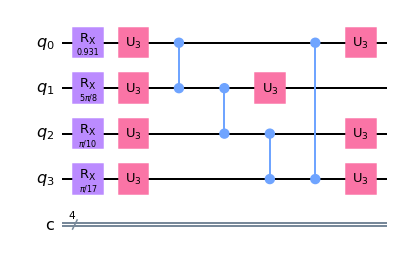

In [23]:
qcircuit = createCircuit(vqc.bestparams, X_train[0])
qcircuit.draw(output='mpl')